In [1]:
import os
import json
from iqcc_cloud_client import IQCC_Cloud

# Set your quantum computer backend
quantum_computer_backend = "gilboa"  # for example qc_qwfix
iqcc = IQCC_Cloud(quantum_computer_backend=quantum_computer_backend)
# Get the latest state and wiring files
latest_wiring = iqcc.state.get_latest("wiring")
latest_state = iqcc.state.get_latest("state")

# Get the state folder path from environment variable
quam_state_folder_path = os.environ["QUAM_STATE_PATH"]

# Save the files
with open(os.path.join(quam_state_folder_path, "wiring.json"), "w") as f:
    json.dump(latest_wiring.data, f, indent=4)

with open(os.path.join(quam_state_folder_path, "state.json"), "w") as f:
    json.dump(latest_state.data, f, indent=4)

2025-05-29 09:44:13,953 - qm - INFO     - Starting session: 218bd980-71f7-4913-92b2-d250e5550745


In [2]:
from typing import Any
import warnings

from qm import QuantumMachinesManager, SimulationConfig
from qm.qua import *
from qm_saas import QoPVersion, QmSaas
from quam_libs.components import (
    MeasureMacro,
    ResetMacro,
    VirtualZMacro,
    CZMacro,
    DelayMacro,
)
from qiskit_qm_provider import (
    FluxTunableTransmonBackend,
    ParameterTable,
    Parameter as QuaParameter,
)
from quam.components.macro import PulseMacro
from quam.core.operation.operations_registry import OperationsRegistry
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector, QuantumRegister
import qiskit.pulse as qp
from qiskit import transpile
import matplotlib.pyplot as plt
from qm import generate_qua_script
import numpy as np
from quam_builder.architecture.superconducting.qpu.flux_tunable_quam import (
    FluxTunableQuam as QuAM,
)
from quam_libs.components.quam_root import QuAM as IQCC_Quam
import warnings
import logging

# Silence DeprecationWarnings from qiskit.pulse
warnings.filterwarnings("ignore", category=DeprecationWarning, module=r"qiskit\.pulse")
# Filter all DeprecationWarnings
logging.getLogger("qiskit").setLevel(logging.ERROR)
file_path = "/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/pulse_level/qua/quam_state"
machine = IQCC_Quam.load()

In [3]:
for qubit in machine.active_qubits:
    qubit.macros["x"] = PulseMacro(pulse="x180")
    qubit.macros["rz"] = VirtualZMacro()
    qubit.macros["sx"] = PulseMacro(pulse="x90")
    qubit.macros["sy"] = PulseMacro(pulse="y90")
    qubit.macros["sydg"] = PulseMacro(pulse="-y90")
    qubit.macros["measure"] = MeasureMacro(pulse="readout")
    qubit.macros["reset"] = ResetMacro(pi_pulse="x180", readout_pulse="readout")
    qubit.macros["delay"] = DelayMacro()

In [4]:
backend = FluxTunableTransmonBackend(machine)
print(backend.target)

Target: Transmon based QuAM
Number of qubits: 5
Instructions:
	x
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	rz
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	sx
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	sy
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	sydg
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	measure
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	reset
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	delay
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	if_else
	while_loop
	for_loop
	switch_case



In [5]:
from rl_qoc.rewards.real_time_utils import get_real_time_reward_circuit
from rl_qoc import (
    QEnvConfig,
    QiskitConfig,
    ExecutionConfig,
    BenchmarkConfig,
    GateTargetConfig,
)
from rl_qoc.rewards import StateReward
from rl_qoc.qua import QMConfig, QMEnvironment

from gymnasium.spaces import Box


def apply_parameters(qc: QuantumCircuit, params: ParameterVector, qreg: QuantumRegister, *args):
    idx_0 = qreg.index(qreg[0])

    if len(qreg) > 1:
        idx_1 = qreg.index(qreg[1])
        with qp.build(backend) as sched:
            qp.play(qp.Constant(duration=120, amp=0.1), backend.flux_channel(idx_0))
            qp.play(
                qp.Constant(duration=120, amp=params[0]),
                backend.control_channel((idx_0, idx_1))[0],
            )
        qc.add_calibration(
            "rzz",
            [0, 1],
            sched,
            params.params if isinstance(params, ParameterVector) else params,
        )
        qc.rzz(params[0], qreg[0], qreg[1])
    else:
        with qp.build(backend) as sched:
            qp.play(
                qp.Drag(duration=120, amp=params[0], sigma=40, beta=0.2),
                backend.drive_channel(idx_0),
            )
        qc.add_calibration(
            "rx",
            [
                0,
            ],
            sched,
            params.params if isinstance(params, ParameterVector) else params,
        )
        qc.rx(params[0], qreg[0])
    with qp.build(backend, name="x_custom") as sched:
        qp.play(
            qp.Drag(duration=120, amp=0.3, sigma=40, beta=0.2),
            backend.drive_channel(idx_0),
        )
    qc.add_calibration(
        "x",
        [
            0,
        ],
        sched,
    )
    qc.add_calibration(
        "x",
        [
            1,
        ],
        sched,
    )


physical_qubits = [0]
gate = "cz" if len(physical_qubits) > 1 else "x"
n_reps = [2, 5]
config = QEnvConfig(
    target=GateTargetConfig(physical_qubits, gate),
    backend_config=QiskitConfig(
        backend=backend,
        parametrized_circuit=apply_parameters,
    ),
    execution_config=ExecutionConfig(
        batch_size=1,
        n_shots=100,
        n_reps=n_reps,
        control_flow_enabled=True,
    ),
    reward=StateReward("pauli4"),
    action_space=Box(low=-1, high=1, shape=(1,), dtype=np.float32),
)

qm_config_args = {
    "input_type": "INPUT_STREAM",
    "num_updates": 500,
}
config.backend_config = QMConfig(**config.backend_config.as_dict(), **qm_config_args)

q_env = QMEnvironment(config)

/var/folders/5w/ygx15jq94z5dzxwkmbbj8zfm0000gn/T/ipykernel_29866/2154313033.py:34: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with qp.build(backend) as sched:
/var/folders/5w/ygx15jq94z5dzxwkmbbj8zfm0000gn/T/ipykernel_29866/2154313033.py:35: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  qp.play(
/var/folders/5w/ygx15jq94z5dzxwkmbbj8zfm0000gn/T/ipykernel_29866/2154313033.py:39: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.add_calibration()`` is deprecated as of Qiskit 1.3

In [6]:
q_env.rl_qoc_training_qua_prog()

In [4]:
from qm import generate_qua_script

print(
    generate_qua_script(
        backend.quantum_circuit_to_qua(q_env.real_time_circuit).result_program.dsl_program
    )
)


# Single QUA script generated at 2025-05-26 13:39:10.256848
# QUA library version: 1.2.2rc2+dgx2


from qm import CompilerOptionArguments
from qm.qua import *

with program() as prog:
    input_stream_a_0_0 = declare_input_stream(fixed, 'a_0_0', value=0.0)
    input_stream_observable_1 = declare_input_stream(int, 'observable_1', value=0)
    input_stream_n_reps = declare_input_stream(int, 'n_reps', value=0)
    input_stream_input_state_1 = declare_input_stream(int, 'input_state_1', value=0)
    input_stream_input_state_0 = declare_input_stream(int, 'input_state_0', value=0)
    input_stream_observable_0 = declare_input_stream(int, 'observable_0', value=0)
    a1 = declare(bool, value=[False, False])
    v1 = declare(int, value=0)
    v2 = declare(int, value=0)
    v3 = declare(int, value=0)
    v4 = declare(int, value=0)
    v5 = declare(int, value=0)
    v6 = declare(fixed, value=0.0)
    v7 = declare(bool, )
    v8 = declare(fixed, )
    v9 = declare(fixed, )
    v10 = declare(fixed

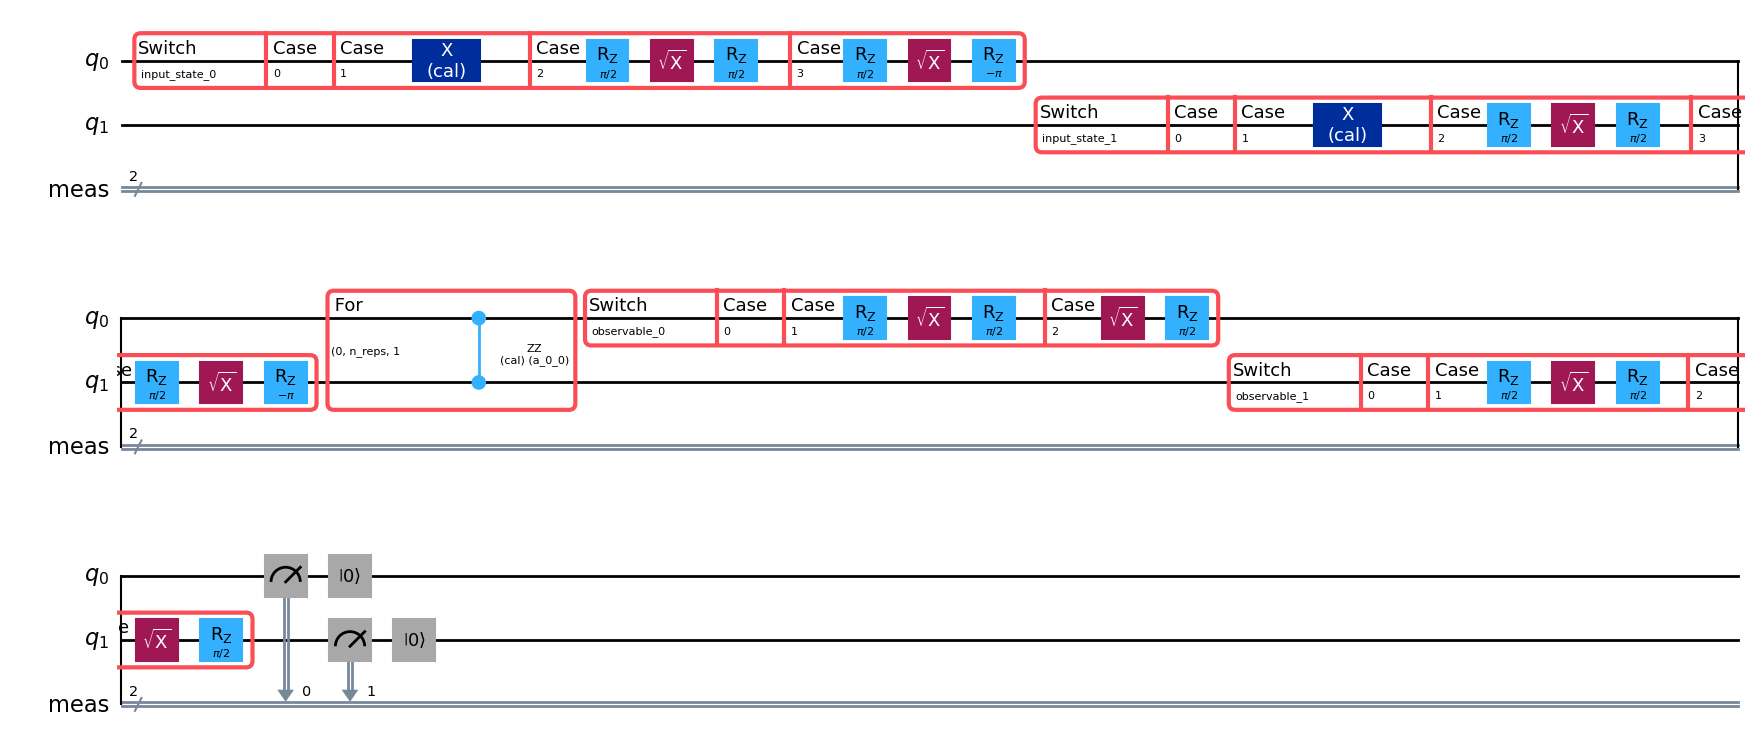

In [5]:
q_env.real_time_circuit.draw("mpl", idle_wires=False, with_layout=False)

In [6]:
print(backend.target)

Target: Transmon based QuAM
Number of qubits: 5
Instructions:
	x
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	rz
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	sx
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	measure
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	reset
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	delay
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	cz
		(0, 1)
		(1, 2)
		(2, 3)
		(3, 4)
	if_else
	while_loop
	for_loop
	switch_case



In [7]:
q_env.real_time_circuit.calibrations

/var/folders/5w/ygx15jq94z5dzxwkmbbj8zfm0000gn/T/ipykernel_3364/620505994.py:1: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.calibrations`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics. Note that once removed, ``qiskit.circuit.quantumcircuit.QuantumCircuit.calibrations`` will have no alternative in Qiskit.
  q_env.real_time_circuit.calibrations


{'rzz': {((0, 1),
   (Parameter(a_0_0),)): ScheduleBlock(Play(Constant(duration=120, amp=0.1, angle=0.0, name='block0_0'), FluxChannel(0)), Play(Constant(duration=120, amp=a_0_0, angle=0.0, name='block0_1'), ControlChannel(0)), name="block0", transform=AlignLeft())},
 'x': {((0,),
   ()): ScheduleBlock(Play(Drag(duration=120, sigma=40, beta=0.2, amp=0.3, angle=0.0, name='x_custom_014771845584'), DriveChannel(0)), name="x_custom", transform=AlignLeft()),
  ((1,),
   ()): ScheduleBlock(Play(Drag(duration=120, sigma=40, beta=0.2, amp=0.3, angle=0.0, name='x_custom_014771845584'), DriveChannel(0)), name="x_custom", transform=AlignLeft())}}

In [7]:
from qm import generate_qua_script

prog = q_env.rl_qoc_training_qua_prog()
print(generate_qua_script(prog))


# Single QUA script generated at 2025-05-29 09:45:04.578823
# QUA library version: 1.2.2rc2+dgx2


from qm import CompilerOptionArguments
from qm.qua import *

with program() as prog:
    input_stream_a_0_0 = declare_input_stream(fixed, 'a_0_0', value=0.0)
    input_stream_max_input_state = declare_input_stream(int, 'max_input_state', value=0)
    input_stream_input_state_0 = declare_input_stream(int, 'input_state_0', value=0)
    input_stream_mu = declare_input_stream(fixed, 'mu', value=[0.0])
    v1 = declare(int, )
    input_stream_sigma = declare_input_stream(fixed, 'sigma', value=[1.0])
    v2 = declare(int, )
    input_stream_reward = declare_input_stream(int, 'reward', value=[0, 0])
    v3 = declare(int, )
    input_stream_n_reps = declare_input_stream(int, 'n_reps', value=2)
    input_stream_observable_0 = declare_input_stream(int, 'observable_0', value=0)
    v4 = declare(int, )
    input_stream_max_observables = declare_input_stream(int, 'max_observables', value=0)
    input

In [7]:
from qiskit_qm_provider import QMInstructionProperties
from qiskit.circuit import Gate

x_test = Gate("x_test", 1, [])


def x_test_macro():
    machine.active_qubits[0].apply("x")


instruction_prop = QMInstructionProperties(qua_pulse_macro=x_test_macro)

In [8]:
backend.target.add_instruction(x_test, {(0,): instruction_prop})

In [106]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.primitives import StatevectorSampler
from qiskit.providers.basic_provider import BasicSimulator
from qiskit_ibm_runtime.fake_provider import FakeJakartaV2
from qiskit import transpile

qreg = QuantumRegister(2, "q")
c1 = ClassicalRegister(2, "c1")
c2 = ClassicalRegister(1, "c2")
qc = QuantumCircuit(qreg, c1, c2)
qc.x(0)
qc.x(1)
qc.measure(0, c1[0])
qc.measure(0, c1[1])
qc.measure(1, c2[0])

sampler = StatevectorSampler()
job = sampler.run([(qc,)], shots=1000)
result = job.result()
fake_backend = FakeJakartaV2()
transpiled_circuit = transpile(qc, backend=fake_backend)
result2 = FakeJakartaV2().run([transpiled_circuit, transpiled_circuit], shots=1000).result()

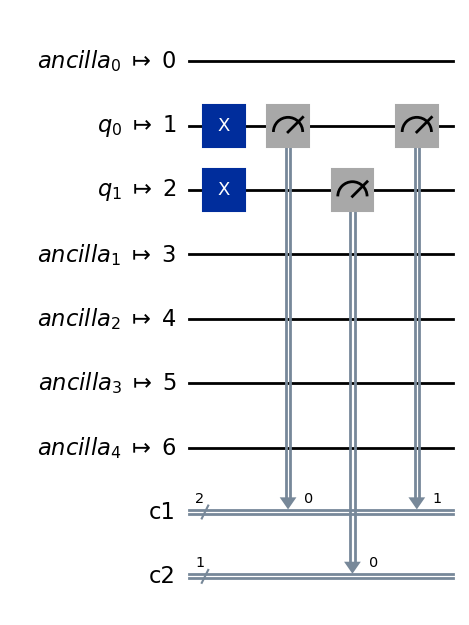

In [107]:
transpiled_circuit.draw("mpl")

In [115]:
result[0].data.c1.get_counts()

{'11': 1000}

In [111]:
result2.get_counts()

[{'0 01': 1, '0 11': 16, '1 10': 20, '1 01': 28, '1 11': 935},
 {'1 10': 23, '1 01': 16, '0 11': 18, '1 11': 943}]

In [116]:
result2

Result(backend_name='aer_simulator', backend_version='0.17.0', qobj_id='', job_id='8d7895d3-9053-4a79-a758-99d1d1ab6e89', success=True, results=[ExperimentResult(shots=1000, success=True, meas_level=2, data=ExperimentResultData(counts={'0x1': 1, '0x3': 16, '0x6': 20, '0x5': 28, '0x7': 935}), header=QobjExperimentHeader(creg_sizes=[['c1', 2], ['c2', 1]], global_phase=0.0, memory_slots=3, n_qubits=7, name='circuit-2763', qreg_sizes=[['q', 7]], metadata={}), status=DONE, seed_simulator=3045177010, metadata={'num_bind_params': 1, 'runtime_parameter_bind': False, 'parallel_state_update': 12, 'parallel_shots': 1, 'sample_measure_time': 9.5791e-05, 'noise': 'superop', 'batched_shots_optimization': False, 'remapped_qubits': True, 'active_input_qubits': [1, 2], 'device': 'CPU', 'time_taken': 0.00073275, 'measure_sampling': True, 'num_clbits': 3, 'max_memory_mb': 18432, 'input_qubit_map': [[2, 1], [1, 0]], 'num_qubits': 2, 'method': 'density_matrix', 'required_memory_mb': 1, 'fusion': {'enabled'

In [38]:
qc.find_bit(qc.clbits[0])

BitLocations(index=0, registers=[(ClassicalRegister(3, 'c1'), 0)])

In [6]:
from pathlib import Path
import json
from qiskit_qm_provider import ParameterPool

path = Path.home() / "qm_saas_config.json"
with open(path, "r") as f:
    config = json.load(f)
email = config["email"]
password = config["password"]
print(config)
# Initialize QOP simulator client
client = QmSaas(email=email, password=password, host="qm-saas.dev.quantum-machines.co")

# Choose your QOP version (QOP2.x.y or QOP3.x.y)
version = QoPVersion.latest
client.close_all()

{'email': 'arthur.strauss@quantum-machines.co', 'password': 'wLf3Qy1Z7xH5'}


In [13]:
from qm import SimulationConfig, LoopbackInterface

config = machine.generate_config()
instance = client.simulator(version=version)
instance.spawn()
# Initialize QuantumMachinesManager with the simulation instance details
qmm = QuantumMachinesManager(
    host=instance.host,
    port=instance.port,
    connection_headers=instance.default_connection_headers,
)
simulation_config = SimulationConfig(
    int(10000),
    include_analog_waveforms=True,
    simulation_interface=LoopbackInterface([("con1", 1, "con1", 1), ("con1", 2, "con1", 2)]),
)
backend.qmm = qmm
backend.set_options(simulate=simulation_config)

2025-05-26 15:43:12,684 - qm - INFO     - Performing health check
2025-05-26 15:43:12 INFO Performing health check
2025-05-26 15:43:12,998 - qm - INFO     - Cluster healthcheck completed successfully.
2025-05-26 15:43:12 INFO Cluster healthcheck completed successfully.


In [6]:
backend._qmm

In [13]:
qc = QuantumCircuit(3)
qc.h(0)
qc.h(1)
qc.h(2)

qc.measure_all()
qc = transpile(qc, backend=backend, optimization_level=0)

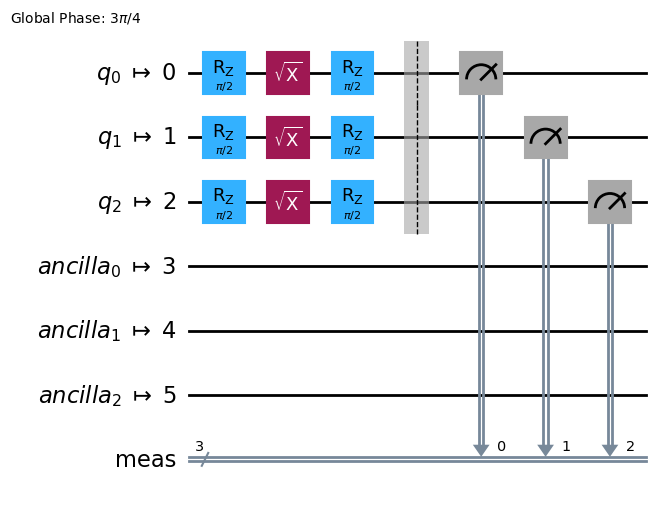

In [14]:
qc.draw("mpl")

In [15]:
qc.layout.final_index_layout(True)

[0, 1, 2]

In [16]:
backend.qmm = iqcc

In [17]:
backend.run(qc, shots=100).result()

/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/quam/components/channels.py:647: UserWarning: The 'thread' element argument is deprecated from qm.qua >= 1.2.2. Use 'core' instead.
  warnings.warn(
/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/qm/program/_qua_config_schema.py:1956: DeprecationWarning: 'version' is deprecated since "1.2.2" and will be removed in "1.3.0". Please remove it from the Qua config.
  warnings.warn(


Output()

[20:17:31] QUA program submitted to arbel (id = e3e4617d-57fb-4777-ba9c-5c93d21ffcc9)              ]8;id=842394;file:///Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/iqcc_cloud_client/computers.py\computers.py]8;;\:]8;id=264942;file:///Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/iqcc_cloud_client/computers.py#442\442]8;;\

[20:17:32] Execution started                                                                       ]8;id=990300;file:///Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/iqcc_cloud_client/computers.py\computers.py]8;;\:]8;id=844537;file:///Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/iqcc_cloud_client/computers.py#462\462]8;;\

[20:18:32] Execution finished                                                                      ]8;id=752583;file:///Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/iqcc_cloud_client/computers.py\computers.py]8;;\:]8;id=29405;file:///Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/iqcc_cloud_client/computers.py#476\476]8;;\

QUA program has error:

Execution timed out after 60

AttributeError: 'NoneType' object has no attribute 'to_bytes'

In [18]:
qc2 = qc.copy_empty_like()
qc2.reset([qc.qubits[i] for i in qc.layout.final_index_layout()])
new_qc = qc.compose(qc2, front=True)
print(generate_qua_script(backend.get_run_program(1000, [new_qc])))


# Single QUA script generated at 2025-05-27 20:18:47.272563
# QUA library version: 1.2.2rc2+dgx2


from qm import CompilerOptionArguments
from qm.qua import *

with program() as prog:
    v1 = declare(int, )
    v2 = declare(int, value=0)
    a1 = declare(bool, value=[False, False, False])
    v3 = declare(fixed, )
    v4 = declare(fixed, )
    v5 = declare(bool, )
    v6 = declare(int, value=1)
    v7 = declare(fixed, )
    v8 = declare(fixed, )
    v9 = declare(bool, )
    v10 = declare(int, value=1)
    v11 = declare(fixed, )
    v12 = declare(fixed, )
    v13 = declare(bool, )
    v14 = declare(int, value=1)
    v15 = declare(bool, )
    v16 = declare(fixed, )
    v17 = declare(fixed, )
    v18 = declare(bool, )
    v19 = declare(fixed, )
    v20 = declare(fixed, )
    v21 = declare(bool, )
    v22 = declare(fixed, )
    v23 = declare(fixed, )
    set_dc_offset("qC1.z", "single", 0.03893272398522141)
    set_dc_offset("qC2.z", "single", 0.042361833295726854)
    set_dc_offset("qC3

In [9]:
machine.active_qubits[1].macros["reset"]

ResetMacro(id='reset', reset_type='active', pi_pulse='x180', readout_pulse='readout', max_attempts=5, thermalize_time=0)

In [58]:
machine.active_qubits[5].T1

1.5818728339088663e-05

In [4]:
from qualang_tools.units import unit

u = unit(coerce_to_integer=True)
for qubit in machine.active_qubits:
    qubit.macros["reset"].reset_type = "thermalize"
    qubit.macros["reset"].thermalize_time = 5 * qubit.T1 * u.s

/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/qualang_tools/units/units.py:60: RuntimeWarning: Warning: the specified duration (0.00016321692632583217) to be converted to clock cycles in not an integer. It has been converted to int (163216.0) to avoid subsequent errors.
  warn(
/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/qualang_tools/units/units.py:60: RuntimeWarning: Warning: the specified duration (0.00014101878302276747) to be converted to clock cycles in not an integer. It has been converted to int (141018.0) to avoid subsequent errors.
  warn(
/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/qualang_tools/units/units.py:60: RuntimeWarning: Warning: the specified duration (0.0001557610809036357) to be converted to clock cycles in not an integer. It has been converted to int (155761.0) to avoid subsequent errors.
  warn(
/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/qualang_to

In [3]:
# Single QUA script generated at 2025-05-27 19:45:27.524398
# QUA library version: 1.2.2rc2+dgx2


from qm import CompilerOptionArguments
from qm.qua import *

with program() as prog:
    v1 = declare(
        int,
    )
    v2 = declare(int, value=0)
    a1 = declare(bool, value=[False])
    v3 = declare(
        fixed,
    )
    v4 = declare(
        fixed,
    )
    v5 = declare(
        bool,
    )
    v6 = declare(int, value=1)
    v7 = declare(
        fixed,
    )
    v8 = declare(
        fixed,
    )
    v9 = declare(
        bool,
    )
    v10 = declare(int, value=1)
    v11 = declare(
        fixed,
    )
    v12 = declare(
        fixed,
    )
    v13 = declare(
        bool,
    )
    v14 = declare(int, value=1)
    v15 = declare(
        fixed,
    )
    v16 = declare(
        fixed,
    )
    v17 = declare(
        bool,
    )
    v18 = declare(int, value=1)
    v19 = declare(
        fixed,
    )
    v20 = declare(
        fixed,
    )
    v21 = declare(
        bool,
    )
    v22 = declare(int, value=1)
    v23 = declare(
        fixed,
    )
    v24 = declare(
        fixed,
    )
    v25 = declare(
        bool,
    )
    v26 = declare(int, value=1)
    v27 = declare(
        bool,
    )
    v28 = declare(
        fixed,
    )
    v29 = declare(
        fixed,
    )
    set_dc_offset("qC1.z", "single", 0.039135714919238104)
    set_dc_offset("qC2.z", "single", 0.04223503506482004)
    set_dc_offset("qC3.z", "single", 0.008778290009488602)
    set_dc_offset("qC4.z", "single", 0.06411332739131062)
    set_dc_offset("qD1.z", "single", 0.12664959452043983)
    set_dc_offset("qD3.z", "single", -0.015130651887161247)
    set_dc_offset("qA1.z", "single", 0.0)
    set_dc_offset("qA2.z", "single", 0.0)
    set_dc_offset("qA3.z", "single", 0.0)
    set_dc_offset("qA4.z", "single", 0.0)
    set_dc_offset("qA5.z", "single", 0.0)
    set_dc_offset("qA6.z", "single", 0.0)
    set_dc_offset("qB1.z", "single", 0.0)
    set_dc_offset("qB2.z", "single", 0.0)
    set_dc_offset("qB3.z", "single", 0.0)
    set_dc_offset("qB4.z", "single", 0.0)
    set_dc_offset("qB5.z", "single", 0.0)
    set_dc_offset("qC5.z", "single", -0.14622362023613197)
    set_dc_offset("qD2.z", "single", 0.0)
    set_dc_offset("qD4.z", "single", 0.0)
    set_dc_offset("qD5.z", "single", 0.0)
    with for_(v1, 0, (v1 < 1000), (v1 + 1)):
        align("qC1.resonator", "qC1.xy", "qC1.z")
        assign(v6, 1)
        align("qC1.resonator", "qC1.xy")
        measure(
            "readout",
            "qC1.resonator",
            dual_demod.full("iw1", "iw2", v3),
            dual_demod.full("iw3", "iw1", v4),
        )
        assign(v5, (v3 > 0.0005470967079245436))
        wait(750, "qC1.resonator")
        align("qC1.resonator", "qC1.xy")
        play("x180_DragCosine", "qC1.xy", condition=v5)
        align("qC1.resonator", "qC1.xy")
        with while_(broadcast.and_((v3 > 0.0001928214925194217), (v6 < 5))):
            align("qC1.resonator", "qC1.xy")
            measure(
                "readout",
                "qC1.resonator",
                dual_demod.full("iw1", "iw2", v3),
                dual_demod.full("iw3", "iw1", v4),
            )
            assign(v5, (v3 > 0.0005470967079245436))
            wait(750, "qC1.resonator")
            align("qC1.resonator", "qC1.xy")
            play("x180_DragCosine", "qC1.xy", condition=v5)
            align("qC1.resonator", "qC1.xy")
            assign(v6, (v6 + 1))
        align("qC1.resonator", "qC1.xy")
        align("qC1.resonator", "qC1.xy", "qC1.z")
        align("qC2.resonator", "qC2.xy", "qC2.z")
        assign(v10, 1)
        align("qC2.resonator", "qC2.xy")
        measure(
            "readout",
            "qC2.resonator",
            dual_demod.full("iw1", "iw2", v7),
            dual_demod.full("iw3", "iw1", v8),
        )
        assign(v9, (v7 > 0.0011967227157967683))
        wait(750, "qC2.resonator")
        align("qC2.resonator", "qC2.xy")
        play("x180_DragCosine", "qC2.xy", condition=v9)
        align("qC2.resonator", "qC2.xy")
        with while_(broadcast.and_((v7 > 0.0005811011731654541), (v10 < 5))):
            align("qC2.resonator", "qC2.xy")
            measure(
                "readout",
                "qC2.resonator",
                dual_demod.full("iw1", "iw2", v7),
                dual_demod.full("iw3", "iw1", v8),
            )
            assign(v9, (v7 > 0.0011967227157967683))
            wait(750, "qC2.resonator")
            align("qC2.resonator", "qC2.xy")
            play("x180_DragCosine", "qC2.xy", condition=v9)
            align("qC2.resonator", "qC2.xy")
            assign(v10, (v10 + 1))
        align("qC2.resonator", "qC2.xy")
        align("qC2.resonator", "qC2.xy", "qC2.z")
        align("qC3.resonator", "qC3.xy", "qC3.z")
        assign(v14, 1)
        align("qC3.resonator", "qC3.xy")
        measure(
            "readout",
            "qC3.resonator",
            dual_demod.full("iw1", "iw2", v11),
            dual_demod.full("iw3", "iw1", v12),
        )
        assign(v13, (v11 > 0.0006555870316205834))
        wait(750, "qC3.resonator")
        align("qC3.resonator", "qC3.xy")
        play("x180_DragCosine", "qC3.xy", condition=v13)
        align("qC3.resonator", "qC3.xy")
        with while_(broadcast.and_((v11 > 0.0003629399072973017), (v14 < 5))):
            align("qC3.resonator", "qC3.xy")
            measure(
                "readout",
                "qC3.resonator",
                dual_demod.full("iw1", "iw2", v11),
                dual_demod.full("iw3", "iw1", v12),
            )
            assign(v13, (v11 > 0.0006555870316205834))
            wait(750, "qC3.resonator")
            align("qC3.resonator", "qC3.xy")
            play("x180_DragCosine", "qC3.xy", condition=v13)
            align("qC3.resonator", "qC3.xy")
            assign(v14, (v14 + 1))
        align("qC3.resonator", "qC3.xy")
        align("qC3.resonator", "qC3.xy", "qC3.z")
        align("qC4.resonator", "qC4.xy", "qC4.z")
        assign(v18, 1)
        align("qC4.resonator", "qC4.xy")
        measure(
            "readout",
            "qC4.resonator",
            dual_demod.full("iw1", "iw2", v15),
            dual_demod.full("iw3", "iw1", v16),
        )
        assign(v17, (v15 > 0.0007501749487191988))
        wait(750, "qC4.resonator")
        align("qC4.resonator", "qC4.xy")
        play("x180_DragCosine", "qC4.xy", condition=v17)
        align("qC4.resonator", "qC4.xy")
        with while_(broadcast.and_((v15 > 0.0005108245760277308), (v18 < 5))):
            align("qC4.resonator", "qC4.xy")
            measure(
                "readout",
                "qC4.resonator",
                dual_demod.full("iw1", "iw2", v15),
                dual_demod.full("iw3", "iw1", v16),
            )
            assign(v17, (v15 > 0.0007501749487191988))
            wait(750, "qC4.resonator")
            align("qC4.resonator", "qC4.xy")
            play("x180_DragCosine", "qC4.xy", condition=v17)
            align("qC4.resonator", "qC4.xy")
            assign(v18, (v18 + 1))
        align("qC4.resonator", "qC4.xy")
        align("qC4.resonator", "qC4.xy", "qC4.z")
        align("qD1.resonator", "qD1.xy", "qD1.z")
        assign(v22, 1)
        align("qD1.resonator", "qD1.xy")
        measure(
            "readout",
            "qD1.resonator",
            dual_demod.full("iw1", "iw2", v19),
            dual_demod.full("iw3", "iw1", v20),
        )
        assign(v21, (v19 > 0.0002586483513194127))
        wait(750, "qD1.resonator")
        align("qD1.resonator", "qD1.xy")
        play("x180_DragCosine", "qD1.xy", condition=v21)
        align("qD1.resonator", "qD1.xy")
        with while_(broadcast.and_((v19 > 0.00011098609197819067), (v22 < 5))):
            align("qD1.resonator", "qD1.xy")
            measure(
                "readout",
                "qD1.resonator",
                dual_demod.full("iw1", "iw2", v19),
                dual_demod.full("iw3", "iw1", v20),
            )
            assign(v21, (v19 > 0.0002586483513194127))
            wait(750, "qD1.resonator")
            align("qD1.resonator", "qD1.xy")
            play("x180_DragCosine", "qD1.xy", condition=v21)
            align("qD1.resonator", "qD1.xy")
            assign(v22, (v22 + 1))
        align("qD1.resonator", "qD1.xy")
        align("qD1.resonator", "qD1.xy", "qD1.z")
        align("qD3.resonator", "qD3.xy", "qD3.z")
        assign(v26, 1)
        align("qD3.resonator", "qD3.xy")
        measure(
            "readout",
            "qD3.resonator",
            dual_demod.full("iw1", "iw2", v23),
            dual_demod.full("iw3", "iw1", v24),
        )
        assign(v25, (v23 > 0.0004993087543054763))
        wait(750, "qD3.resonator")
        align("qD3.resonator", "qD3.xy")
        play("x180_DragCosine", "qD3.xy", condition=v25)
        align("qD3.resonator", "qD3.xy")
        with while_(broadcast.and_((v23 > 0.000352887151506957), (v26 < 5))):
            align("qD3.resonator", "qD3.xy")
            measure(
                "readout",
                "qD3.resonator",
                dual_demod.full("iw1", "iw2", v23),
                dual_demod.full("iw3", "iw1", v24),
            )
            assign(v25, (v23 > 0.0004993087543054763))
            wait(750, "qD3.resonator")
            align("qD3.resonator", "qD3.xy")
            play("x180_DragCosine", "qD3.xy", condition=v25)
            align("qD3.resonator", "qD3.xy")
            assign(v26, (v26 + 1))
        align("qD3.resonator", "qD3.xy")
        align("qD3.resonator", "qD3.xy", "qD3.z")
        align("qC1.resonator", "qC1.xy", "qC1.z")
        play("x180_DragCosine", "qC1.xy")
        align("qC1.resonator", "qC1.xy", "qC1.z")
        align("qC1.resonator", "qC1.xy", "qC1.z")
        measure(
            "readout",
            "qC1.resonator",
            dual_demod.full("iw1", "iw2", v28),
            dual_demod.full("iw3", "iw1", v29),
        )
        assign(v27, (v28 > 0.0005470967079245436))
        align("qC1.resonator", "qC1.xy", "qC1.z")
        assign(a1[0], v27)
        assign(v2, (v2 + (1 * Cast.to_int(a1[0]))))
        r1 = declare_stream()
        save(v2, r1)
        assign(v2, 0)
    with stream_processing():
        r1.save_all("meas_0")

config = None

loaded_config = None

In [4]:
result = iqcc.execute(prog, machine.generate_config())

/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/quam/components/channels.py:647: UserWarning: The 'thread' element argument is deprecated from qm.qua >= 1.2.2. Use 'core' instead.
  warnings.warn(
/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/qm/program/_qua_config_schema.py:1956: DeprecationWarning: 'version' is deprecated since "1.2.2" and will be removed in "1.3.0". Please remove it from the Qua config.
  warnings.warn(


Output()

[17:15:27] QUA program submitted to arbel (id = 44251a80-e9ed-4625-a95a-0bbe27138265)              ]8;id=991298;file:///Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/iqcc_cloud_client/computers.py\computers.py]8;;\:]8;id=979372;file:///Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/iqcc_cloud_client/computers.py#442\442]8;;\

[17:15:28] Execution started                                                                       ]8;id=662265;file:///Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/iqcc_cloud_client/computers.py\computers.py]8;;\:]8;id=744087;file:///Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/iqcc_cloud_client/computers.py#462\462]8;;\

[17:15:31] Execution finished                                                                      ]8;id=692565;file:///Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/iqcc_cloud_client/computers.py\computers.py]8;;\:]8;id=309662;file:///Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/iqcc_cloud_client/computers.py#476\476]8;;\

QUA program has error:

Traceback (most recent call last):
  File "/app/.venv/lib/python3.11/site-packages/qm/api/v2/base_api_v2.py", line 24, in _run
    return response.success
           ^^^^^^^^^^^^^^^^
  File "/app/.venv/lib/python3.11/site-packages/betterproto/__init__.py", line 840, in __getattribute__
    raise AttributeError(
AttributeError: 'response_oneof' is set to 'error', not 'success'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/app/.venv/lib/python3.11/site-packages/qm/api/v2/qm_api.py", line 195, in _add_program
    response = self._run(self._stub.add_to_queue(request, timeout=self._timeout))
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/app/.venv/lib/python3.11/site-packages/qm/api/base_api.py", line 53, in wrapped
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/app/.venv/lib/python3.11/site-packages/qm/api/v2/base_api_v2.py", line 26, in _run
    raise QopResponseError(error=response.error)
qm.exceptions.QopResponseError: Error from QOP, details:
Compilation failed.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/app/temp.py", line 17110, in <module>
    qm_job = qm.execute(prog)
             ^^^^^^^^^^^^^^^^
  File "/app/.venv/lib/python3.11/site-packages/qm/api/v2/qm_api_old.py", line 173, in execute
    new_job_api = self.add_to_queue(program, compiler_options=compiler_options)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/app/.venv/lib/python3.11/site-packages/qm/api/v2/qm_api.py", line 242, in add_to_queue
    return self._add_program(program)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/app/.venv/lib/python3.11/site-packages/qm/api/v2/qm_api.py", line 206, in _add_program
    raise FailedToExecuteJobException(
qm.exceptions.FailedToExecuteJobException: Failed to execute program. See the following errors:
Internal error. Please report it to QM (ts=1748337330277)

In [13]:
from qiskit.primitives.containers import BitArray

integers = np.array(result["result"]["meas_0"])
integers.flatten()
res = BitArray.from_samples(integers.flatten().tolist(), 1)

In [14]:
res.get_counts()

{'1': 486, '0': 514}

In [12]:
result

{'result': {'meas_0': [[1],
   [0],
   [1],
   [0],
   [1],
   [1],
   [1],
   [1],
   [1],
   [1],
   [1],
   [1],
   [1],
   [1],
   [1],
   [1],
   [0],
   [1],
   [0],
   [1],
   [0],
   [1],
   [0],
   [1],
   [0],
   [1],
   [0],
   [0],
   [0],
   [0],
   [1],
   [0],
   [1],
   [0],
   [1],
   [0],
   [1],
   [0],
   [1],
   [0],
   [1],
   [0],
   [1],
   [0],
   [1],
   [0],
   [1],
   [0],
   [1],
   [0],
   [1],
   [0],
   [1],
   [0],
   [1],
   [0],
   [1],
   [0],
   [1],
   [0],
   [0],
   [1],
   [0],
   [0],
   [0],
   [1],
   [0],
   [0],
   [1],
   [0],
   [1],
   [0],
   [1],
   [0],
   [1],
   [0],
   [1],
   [0],
   [1],
   [1],
   [1],
   [0],
   [1],
   [1],
   [1],
   [0],
   [0],
   [1],
   [0],
   [1],
   [0],
   [1],
   [0],
   [1],
   [0],
   [1],
   [0],
   [1],
   [0],
   [0],
   [1],
   [0],
   [1],
   [0],
   [0],
   [0],
   [0],
   [1],
   [0],
   [1],
   [0],
   [1],
   [0],
   [1],
   [0],
   [0],
   [1],
   [0],
   [1],
   [0],
   [1],
   [0],
   [